Example: *gmimtools*
===================

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyrotd
import gmimtools

In [4]:
pyrotd.processes = 1

# Input

In [6]:
path = './Data/1989_LomaPrieta_TreasureIsland/'
path = './Data/1994_Northridge_RRS/'
path = './Data/2023_Pazarcik_TK_0125/'

In [7]:
scaling = 9.81 # To convert acceleration units

In [8]:
files = os.listdir(path)
file  = files[1]

# Read acceleration time series

In [10]:
[accel,dt] = gmimtools.read_AT2(path+file,scaling)
gmtime     = np.linspace(dt,dt*len(accel),len(accel))

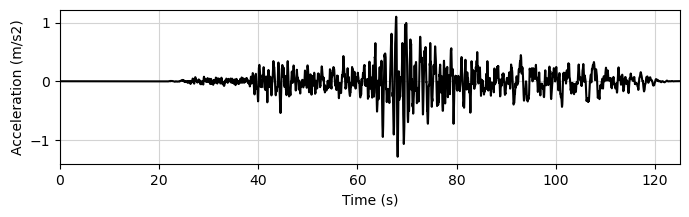

In [11]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(gmtime,accel,'k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration (m/s2)')
ax.set_xlim([0,gmtime[-1]])
plt.grid(which='both',color='lightgray')
plt.show()
plt.close()

# Compute ground motion intensity measures

## PGA

In [14]:
PGA = gmimtools.get_PGA_cy(accel)
print('PGA = {:.3f} m/s2'.format(PGA))

PGA = 1.286 m/s2


## PGV

In [16]:
PGV = gmimtools.get_PGV_cy(accel,dt)
print('PGV = {:.3f} m/s'.format(PGV))

PGV = 0.336 m/s


## Ia

In [18]:
[Ia,Ia_hist] = gmimtools.get_Ia_cy(accel,dt)
print('Ia = {:.3f} m/s'.format(Ia))

Ia = 0.717 m/s


## Ia times

In [20]:
percentages = np.array([0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95])

In [21]:
Ia_times = gmimtools.get_Ia_times_cy(accel,dt,percentages)

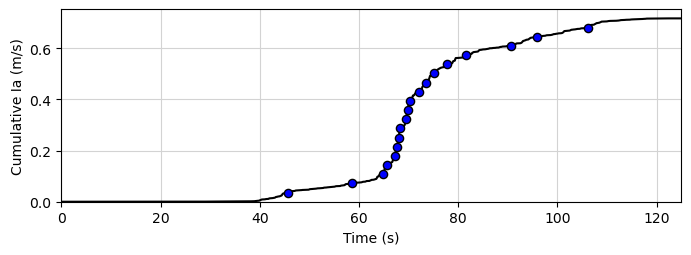

In [22]:
fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(gmtime,Ia_hist,'k')
ax.scatter(Ia_times,Ia*percentages,zorder=2,s=35,facecolor='b',edgecolor='k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cumulative Ia (m/s)')
ax.set_xlim([0,gmtime[-1]])
ax.set_ylim([0,None])
plt.grid(which='both',color='lightgray')
plt.show()
plt.close()

## CAV

In [24]:
CAV = gmimtools.get_CAV_cy(accel,dt)
print('CAV = {:.3f} m/s'.format(CAV))

CAV = 13.717 m/s


## CAV5

In [26]:
CAV5 = gmimtools.get_CAVn_cy(accel,dt,0.05)
print('CAV5 = {:.3f} m/s'.format(CAV5))

CAV5 = 12.915 m/s


## CAVstd

In [28]:
CAVstd = gmimtools.get_CAVstd_cy(accel,dt)
print('CAVstd = {:.3f} m/s'.format(CAVstd))

CAVstd = 11.544 m/s


## CAVdp

#### Read three-component record

In [31]:
[accel_H1,dt] = gmimtools.read_AT2(path+files[0],scaling)
[accel_H2,dt] = gmimtools.read_AT2(path+files[1],scaling)
[accel_V,dt]  = gmimtools.read_AT2(path+files[2],scaling)

#### Compute PSA

In [33]:
osc_damping = 0.05

In [34]:
freqs1 = np.logspace(0,np.log10(2),30)
freqs2 = np.logspace(np.log10(2),1,30)
freqs  = np.unique(np.concatenate([freqs1,freqs2]))

In [35]:
PSA_H1 = pyrotd.calc_spec_accels(dt,accel_H1,freqs,osc_damping).spec_accel
PSA_H2 = pyrotd.calc_spec_accels(dt,accel_H2,freqs,osc_damping).spec_accel
PSA_V  = pyrotd.calc_spec_accels(dt,accel_V,freqs,osc_damping).spec_accel

#### Compute PSV

In [37]:
w_freq = 2*np.pi*freqs
PSV_H1 = PSA_H1/w_freq
PSV_H2 = PSA_H2/w_freq
PSV_V  = PSA_V/w_freq

#### Compute CAVstd

In [39]:
CAVstd_H1 = gmimtools.get_CAVstd_cy(accel_H1,dt)
CAVstd_H2 = gmimtools.get_CAVstd_cy(accel_H2,dt)
CAVstd_V  = gmimtools.get_CAVstd_cy(accel_V,dt)

#### Compute CAVdp

In [41]:
PSA_max = max(np.max(PSA_H1[freqs>=2]),np.max(PSA_H2[freqs>=2]),np.max(PSA_V[freqs>=2]))
PSV_max = max(np.max(PSA_H1[freqs<=2]),np.max(PSA_H2[freqs<=2]),np.max(PSA_V[freqs<=2]))
CAVstd_max = max(CAVstd_H1,CAVstd_H2,CAVstd_V)
CAVstd_gm  = (CAVstd_H1*CAVstd_H2)**0.5

In [42]:
CAVdp = gmimtools.get_CAVdp_cy(CAVstd_gm,CAVstd_max,PSA_max,PSV_max)
print('CAVdp = {:.3f} m/s'.format(CAVdp))

CAVdp = 10.629 m/s


## Summary

In [44]:
table = pd.DataFrame({
    'GMIMs': ['PGA','PGV','Ia','CAV','CAV5','CAVstd','CAVdp'],
    'Unit':  ['m/s2','m/s','m/s','m/s','m/s','m/s','m/s'],
    'Value': [PGA,PGV,Ia,CAV,CAV5,CAVstd,CAVdp]
})
table

,GMIMs,Unit,Value
0,PGA,m/s2,1.286023
1,PGV,m/s,0.335510
2,Ia,m/s,0.717027
3,CAV,m/s,13.717308
4,CAV5,m/s,12.914516
5,CAVstd,m/s,11.544224
6,CAVdp,m/s,10.629479
